# Лабораторная работа №4 - Системы с прямой адаптацией
Уравнения объекта и регулятора основного контура (без адаптации).

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;G\;*\;tanh\left(I\right)\;-\;1$

$I = c_1 dP + c_2 T + c_3$

Установка и импорт вспомогательных пакетов

In [9]:
!pip install digicon_mod

In [10]:
import math
import numpy
import matplotlib.pyplot as plt

import digicon_mod

## 1. Определение вспомогательных объектов в Python
Определяем модель объекта.

In [11]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                zeta = finish_value
            else:
                zeta = init_value
            d_dP=17 * x[1] + zeta - 0.1 * math.pow(x[0],3) + 9 * math.sin(4 * x[0] - 7) - 6
            dT=-0.1 * math.pow(x[1],3) - 2 * x[1] * math.cos(5 * x[0] + 6) + uc - 1
            return [d_dP, dT]

        return F_internal
    return F_with_control

In [12]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')
    plt.ylim([-2.0, 2.0])
    plt.show()

Базовый класс для реализации регулятора, программа моделирования и вывода результатов на экран.

### 2. Адаптивный регулятор с обобщённой ошибкой настройки
Реализация алгоритма адаптивного управления.

In [128]:
class ADCS_gerr(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_gerr,self).__init__(gain,step=dt)
        self.g = speed
        self.P_d = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'y':[], 'dy':[], 'ddy':[], 'sigma':[]}
        self.y_last = None
        self.y_last_last = None

    def optimize(self, x, t):
        y = x[0] - self.P_d
        self.coeff['t'].append(t)
        self.coeff['y'].append(y)
        if self.y_last_last is not None:
            dy = (y - self.y_last)/self.dt
            ddy = (y - 2.0*self.y_last + self.y_last_last) / (self.dt**2)
            sigma = ddy + 3.0*dy + 2.0*y
            self.coeff['sigma'].append(sigma)

            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]

            c1 = c1 - self.g*sigma*x[0]
            c2 = c2 - self.g*sigma*x[1]
            c3 = c3 - self.g*sigma

            self.coeff['c1'].append(c1)
            self.coeff['c2'].append(c2)
            self.coeff['c3'].append(c3)
        else:
            self.coeff['sigma'].append(0.0)
            self.coeff['c1'].append(self.c10)
            self.coeff['c2'].append(self.c20)
            self.coeff['c3'].append(self.c30)

        if self.y_last is not None:
            self.y_last_last = self.y_last

        self.y_last = y

    def control(self, x, t):
        self.optimize(x, t)

        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]

        return c1*x[0] + c2*x[1] + c3

Моделирование регулятора с функцией обобщённой ошибки

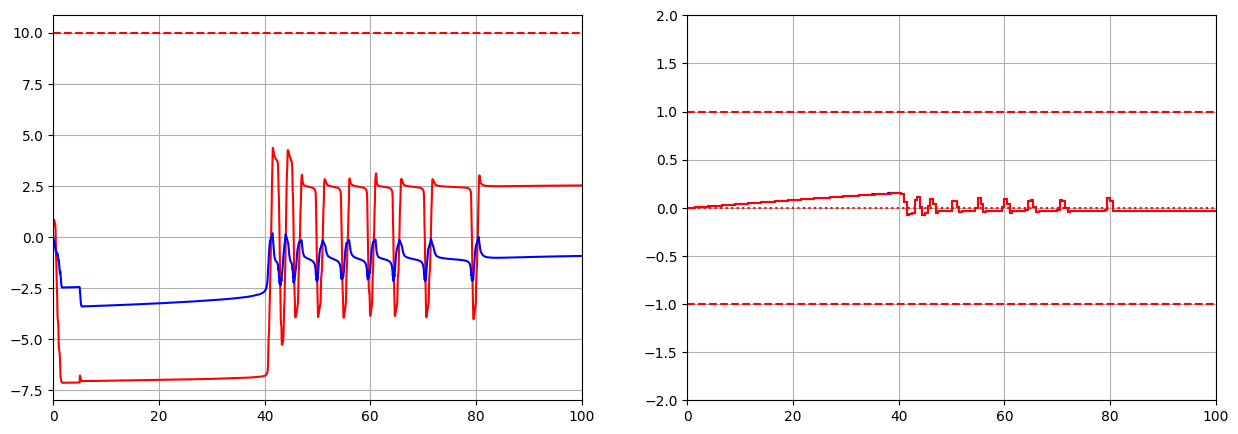

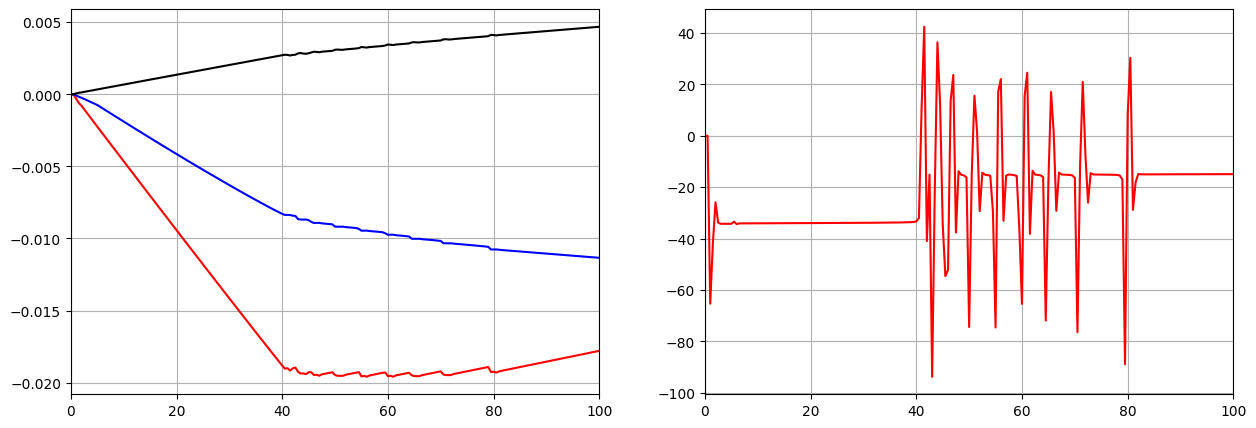

In [192]:
v0_init = 4.0
v0_finish = 23.0
change_time = 5
goal = 10
gain = 30
step = 0.5
mod_step = 0.001
tk = 100
x0 = [0.5, 0.0]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_gerr(goal=goal, gain=gain, dt=step, speed=0.000001)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',# [0, tk], [-1, -1], 'r--',
         reg.coeff['t'], reg.coeff['c2'], 'b',# [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
         reg.coeff['t'], reg.coeff['c3'], 'k')
plt.xlim([0, tk])
plt.grid()
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['sigma'], 'r')# [0, tk], [-1, -1], 'r--',
plt.grid()
plt.xlim([0, tk])
plt.show()

Путём подбора коэффициентов gain, speed, mod_step пришли к наилучшему варианту регулятора.

## 2. Регулятор на базе алгоритма скоростного градиента
Программа расчета управления

In [196]:
class ADCS_spgrad(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_spgrad,self).__init__(gain, dt)
        self.g = speed
        self.P_d = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'y':[], 'Q':[]}

    def optimize(self, x, t):
        y = x[0] - self.P_d
        Q = y**2

        self.coeff['t'].append(t)
        self.coeff['y'].append(y)
        self.coeff['Q'].append(Q)

        if len(self.coeff['c1'])>0:
            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]
        else:
            c1 = 0.0
            c2 = 0.0
            c3 = 0.0

        c1 = c1 - self.g*y*x[0]
        c2 = c2 - self.g*y*x[1]
        c3 = c3 - self.g*y

        self.coeff['c1'].append(c1)
        self.coeff['c2'].append(c2)
        self.coeff['c3'].append(c3)

    def control(self, x, t):
        self.optimize(x, t)

        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]

        return c1*x[0] + c2*x[1] + c3

Моделирование системы с регулятором

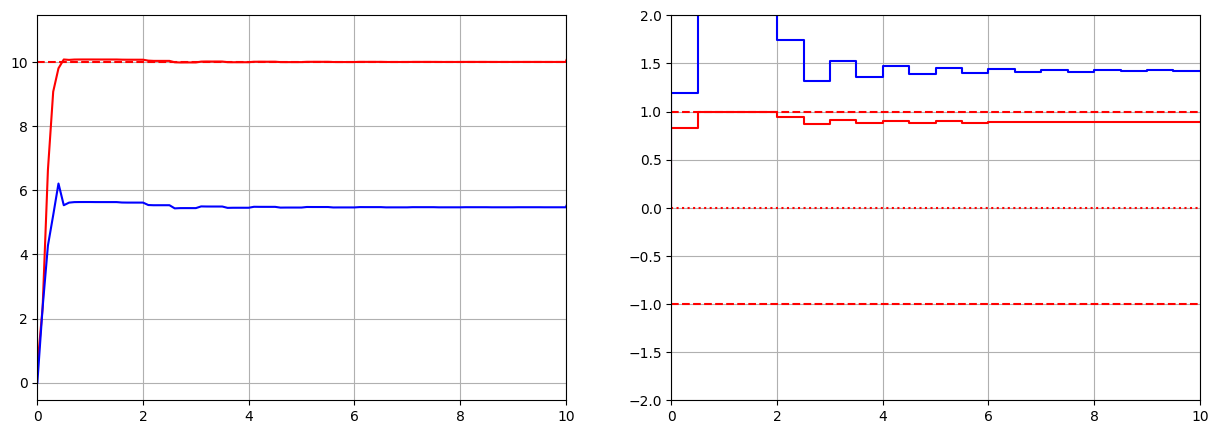

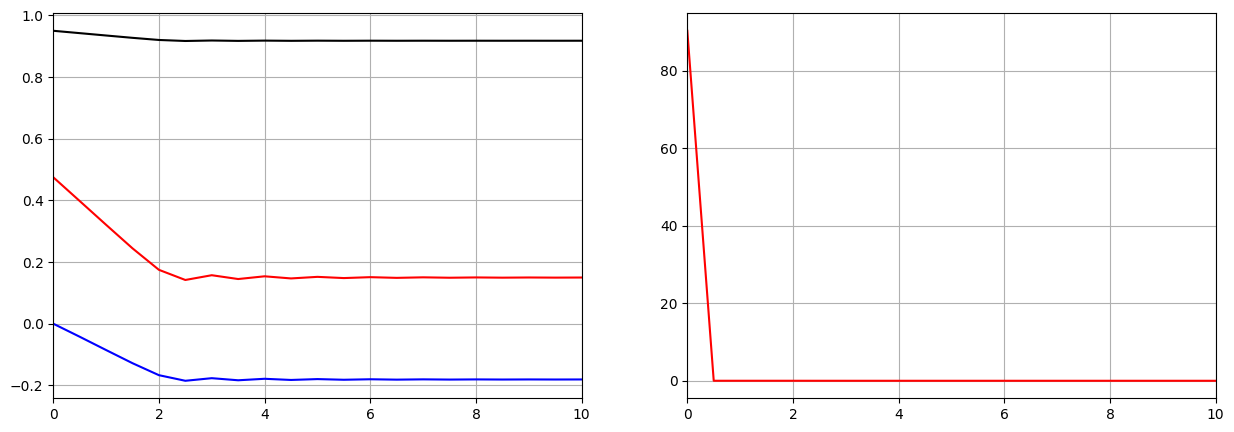

In [207]:
v0_init = 4.0
v0_finish = 23.0
change_time = 10
goal = 10
gain = 30
step = 0.5
mod_step = 0.1
tk = 10
x0 = [0.5, 0.0]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_spgrad(goal=goal, gain=gain, dt=step, speed=0.1)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',
         reg.coeff['t'], reg.coeff['c2'], 'b',
         reg.coeff['t'], reg.coeff['c3'], 'k')
plt.xlim([0, tk])
plt.grid()
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['Q'], 'r')
plt.grid()
plt.xlim([0, tk])
plt.show()

Путём подбора коэффициентов gain, speed, mod_step пришли к наилучшему варианту регулятора.\
Закон управлению по методу градиентного спуска гораздо лучше приводит систему к желаемому значению, в отличии от метода с обобщённой ошибкой настройки.